# ViT Prototype: Multi-Channel Hilbert 32x32 Network Payload Classification

**Objective:** Evaluate Vision Transformer performance on multi-channel Hilbert curve encoded 32x32 image representations of network payloads.

## Overview

This notebook implements a Vision Transformer for **multi-channel Hilbert 32x32 images** combining:
- **Spatial Locality**: Hilbert curve mapping preserves byte adjacency in 2D space
- **Semantic Richness**: 5 channels capturing different aspects of payload data
- **Consistent Mapping**: All channels use the same Hilbert positions for interpretability

## Key Configuration

- **Image Format:** 5-channel 32x32 images with Hilbert curve mapping
- **Dataset Source:** `/home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/multichannel_hilbert_32x32/`
- **Classes:** 9 attack types from CIC-IoT23 dataset
- **Architecture:** ViT with 16×16 patches, adapted for multi-channel input

## Channel Design

1. **Channel 1 (Raw Bytes)**: Direct byte values [0-255] normalized
2. **Channel 2 (Header Emphasis)**: First 64 bytes weighted more heavily
3. **Channel 3 (Byte Frequency)**: Frequency analysis of byte patterns
4. **Channel 4 (Local Entropy)**: Shannon entropy in local neighborhoods
5. **Channel 5 (Gradient Magnitude)**: Rate of change between adjacent bytes

All channels mapped using the same Hilbert curve positions for spatial consistency.

In [1]:
# Section 1: Environment Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for multi-channel Hilbert ViT
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 5,             # 5-channel input with Hilbert mapping
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 192,          # Embedding dimension  
    'num_heads': 3,            # Attention heads
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 9           # 9 attack classes
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Target: Multi-channel Hilbert {CONFIG['channels']}×{CONFIG['image_size']}×{CONFIG['image_size']} → ViT classification")

✓ Environment setup complete
✓ Device: cpu
✓ Target: Multi-channel Hilbert 5×32×32 → ViT classification


In [2]:
# Load multi-channel Hilbert dataset from parquet files
data_path = '/home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/multichannel_hilbert_32x32/'
print(f"Loading multi-channel Hilbert dataset from: {data_path}")

def load_parquet_data(base_path):
    """Load all parquet files from train/val/test splits"""
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    # Get all class directories - SORT for consistency
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]
    print(f"Found classes: {class_names}")
    
    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        print(f"Loading {class_name}...")
        
        for split in splits:
            split_path = f"{class_dir}{split}/"
            parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))  # SORT for consistency
            
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    
                    # Extract image data from the 'image_data' column
                    if 'image_data' in df.columns:
                        # Convert list-based image data to numpy arrays
                        for idx, row in df.iterrows():
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                        
                        print(f"   Loaded {len(df)} samples from {file_path.split('/')[-1]}")
                    else:
                        print(f"   Warning: No 'image_data' column found in {file_path.split('/')[-1]}")
                        
                except Exception as e:
                    print(f"   Error loading {file_path}: {e}")
    
    if not all_image_data:
        raise ValueError("No image data was loaded successfully!")
    
    # Convert to numpy arrays
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n✓ Total samples loaded: {len(X)}")
    print(f"✓ Image data shape: {X.shape}")
    print(f"✓ Unique labels: {np.unique(y)}")
    
    return X, y

# Load the dataset
X, y = load_parquet_data(data_path)

print(f"\n✓ Multi-channel Hilbert data preparation:")
print(f"   X shape: {X.shape}")
print(f"   Expected features: {CONFIG['channels']} × {CONFIG['image_size']}² = {CONFIG['channels'] * CONFIG['image_size']**2}")
print(f"   y shape: {y.shape}")

# Verify the data matches expected dimensions
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    print(f"✓ Feature count matches expected: {X.shape[1]} == {expected_features}")
else:
    print(f"⚠️  Feature count mismatch: got {X.shape[1]}, expected {expected_features}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
actual_classes = len(label_encoder.classes_)

print(f"\n✓ Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

# Verify data quality
print(f"\n✓ Data quality (Multi-channel Hilbert):")
print(f"   Value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"   Missing values: {np.isnan(X).sum()}")
print(f"   Non-zero features per sample (avg): {np.mean(np.count_nonzero(X, axis=1)):.1f}")
print(f"\n✓ Hilbert curve mapping ensures spatial locality across all channels")

Loading multi-channel Hilbert dataset from: /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/multichannel_hilbert_32x32/
Found classes: ['Benign_Final', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'Mirai-udpplain', 'Recon-PortScan', 'SqlInjection']
Loading Benign_Final...
   Loaded 1000 samples from shard_00000.parquet
   Loaded 1000 samples from shard_00001.parquet
   Loaded 1000 samples from shard_00002.parquet
   Loaded 1000 samples from shard_00003.parquet
   Loaded 1000 samples from shard_00004.parquet
   Loaded 1000 samples from shard_00005.parquet
   Loaded 1000 samples from shard_00006.parquet
   Loaded 1000 samples from shard_00007.parquet
   Loaded 369 samples from shard_00008.parquet
   Loaded 1000 samples from shard_00000.parquet
   Loaded 808 samples from shard_00001.parquet
   Loaded 1000 samples from shard_00000.parquet
   Loaded 823 samples from shard_00001.parquet
Loading DDoS-HTTP_Flood...
  

Reshaping data to multi-channel Hilbert images...
✓ Reshaped to: (108000, 5, 32, 32)

Visualizing multi-channel Hilbert images for 9 classes...


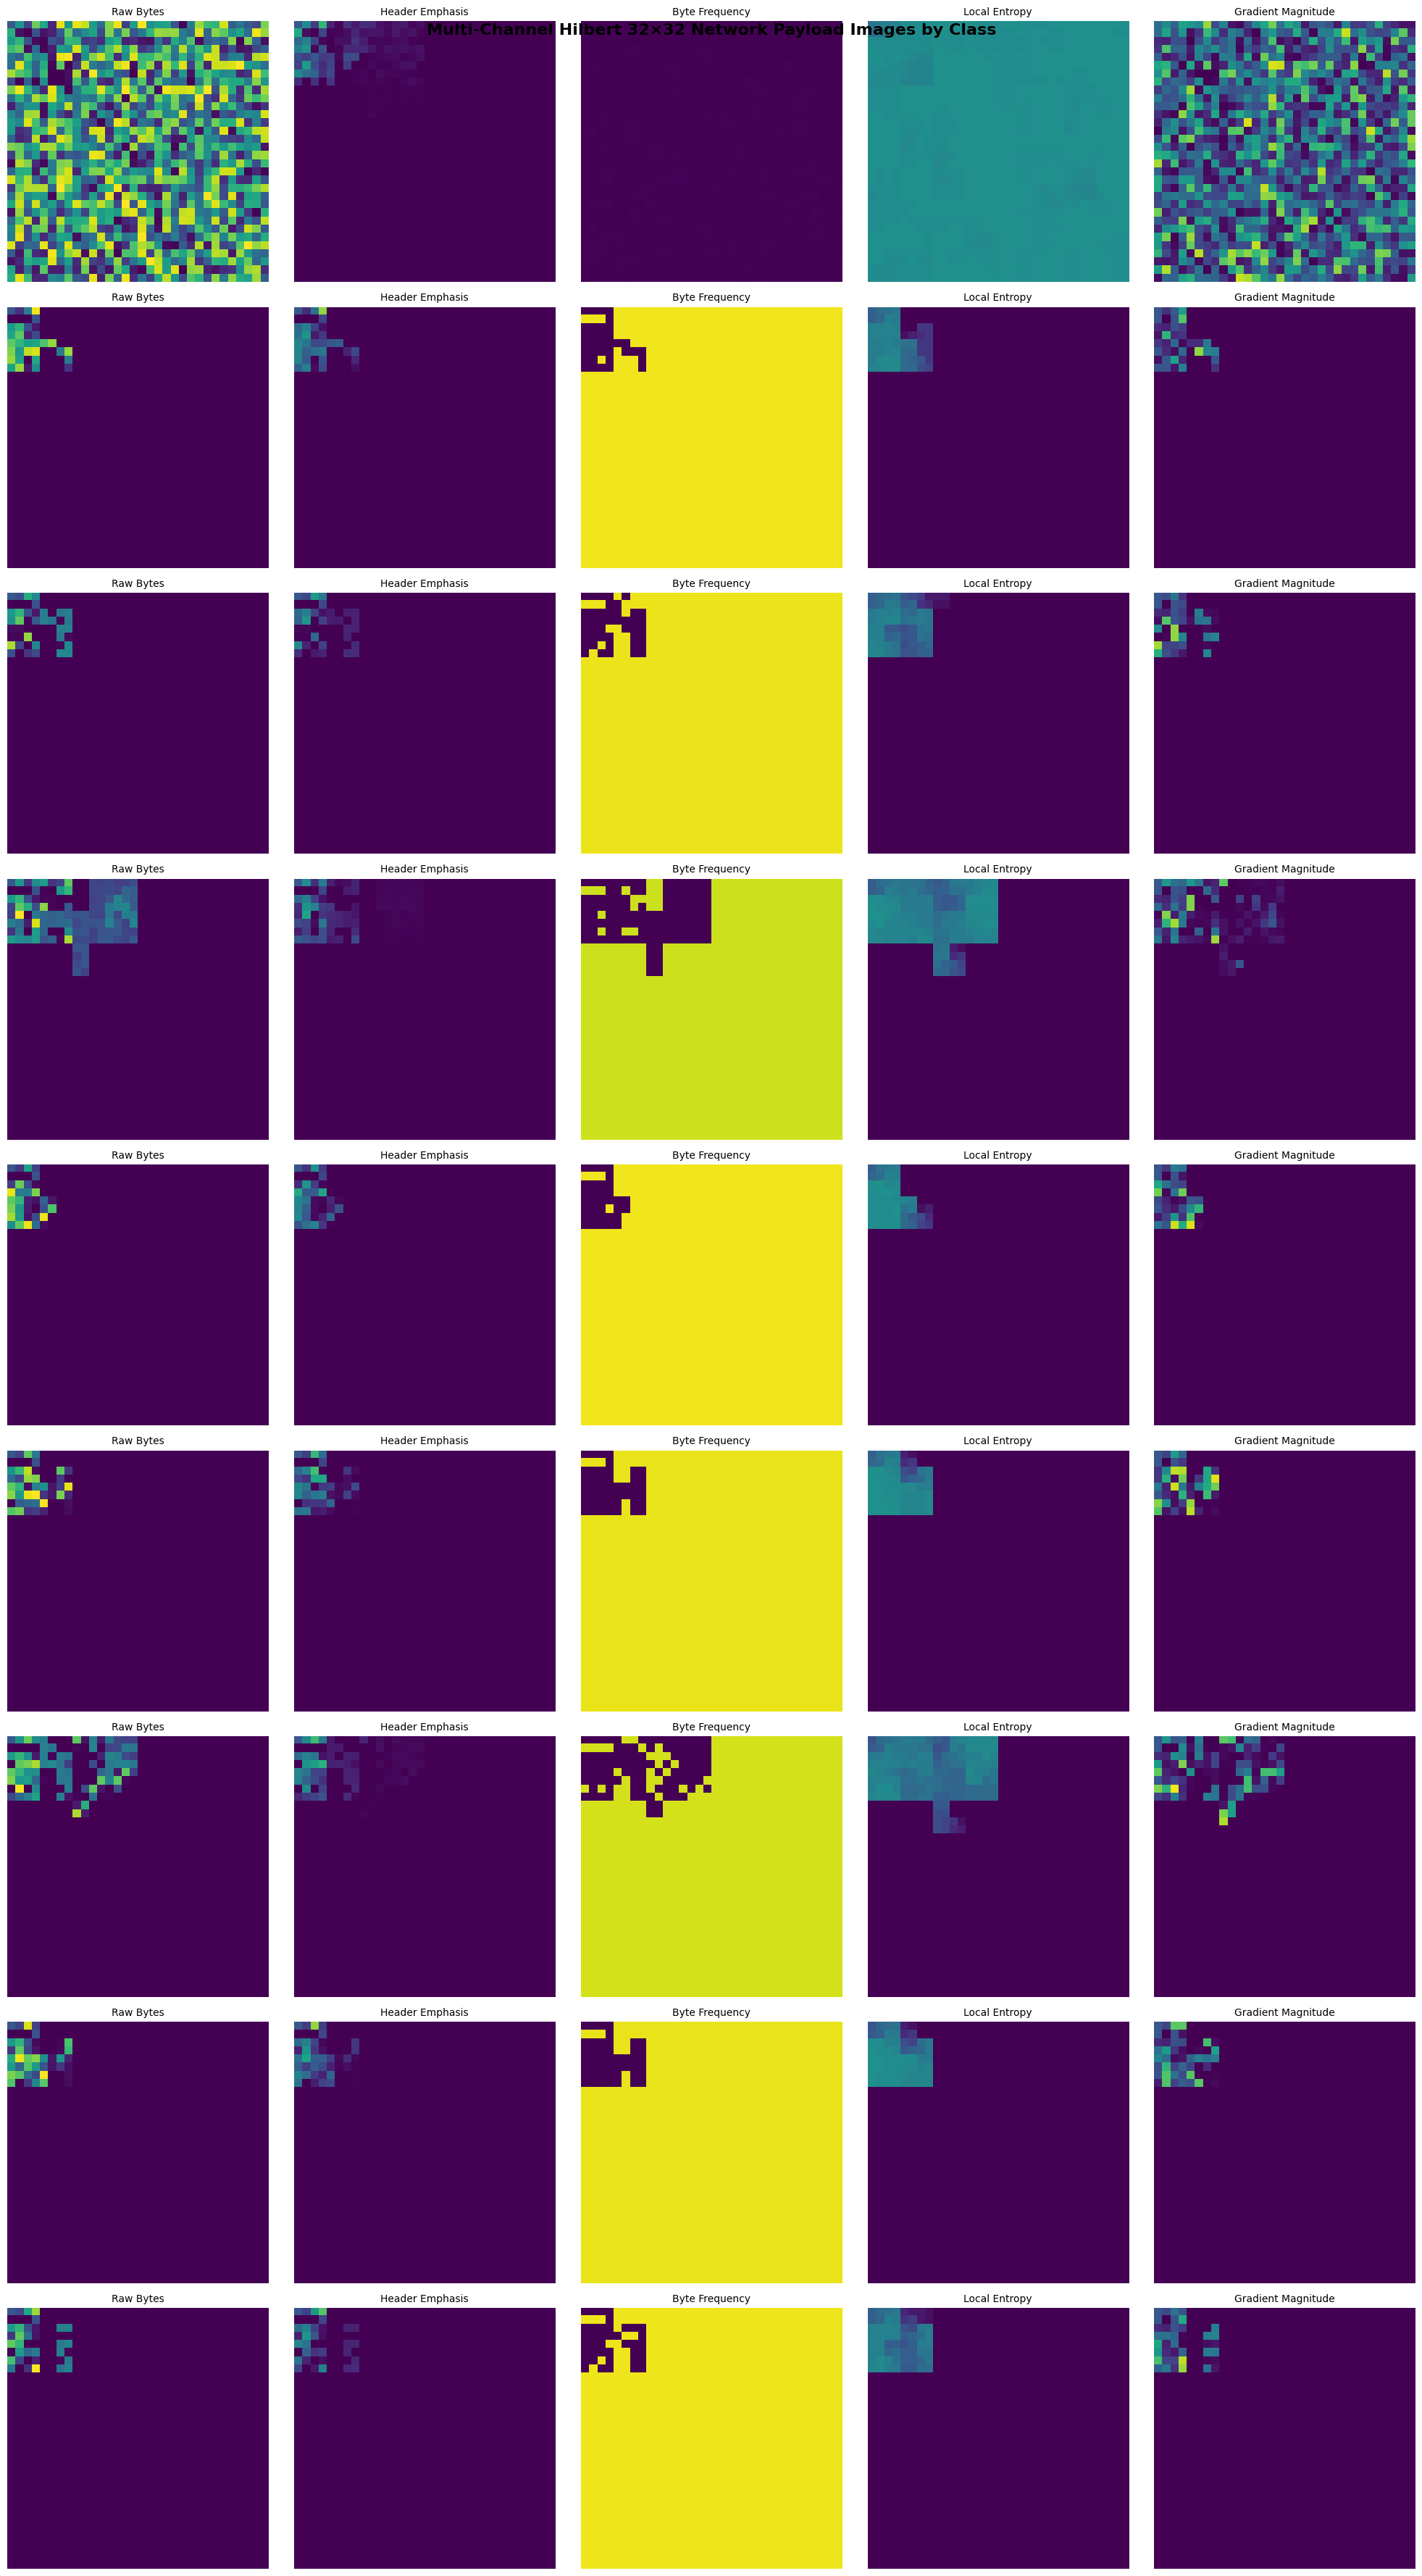


📊 Channel-wise Analysis (Hilbert Mapped):
   Raw Bytes           : mean=0.079, std=0.208, nonzero=0.177
   Header Emphasis     : mean=0.010, std=0.056, nonzero=0.177
   Byte Frequency      : mean=0.776, std=0.366, nonzero=1.000
   Local Entropy       : mean=0.088, std=0.182, nonzero=0.195
   Gradient Magnitude  : mean=0.052, std=0.151, nonzero=0.180

📊 Inter-channel Correlations (Hilbert positions aligned):


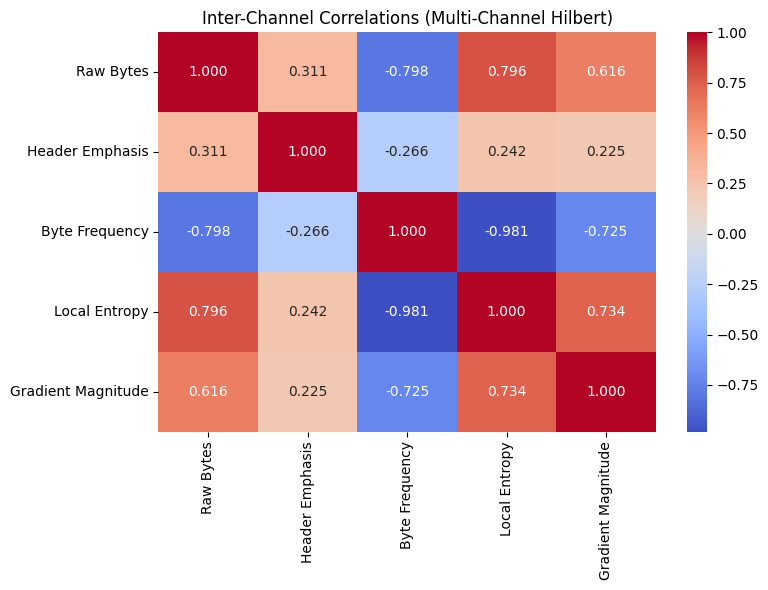


✓ Multi-channel Hilbert visualization complete!
✓ Hilbert curve ensures spatial locality is preserved across all channels
✓ Ready for ViT model training with spatially-consistent multi-channel input


In [3]:
# Section 2: Data Reshaping and Visualization
# Reshape data from flat features to 5-channel images
print("Reshaping data to multi-channel Hilbert images...")

# Expected: (N, 5120) → (N, 5, 32, 32)
X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
print(f"✓ Reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample images for each class with channel interpretations
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(num_classes, CONFIG['channels'], figsize=(20, 4*num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

channel_names = ['Raw Bytes', 'Header Emphasis', 'Byte Frequency', 'Local Entropy', 'Gradient Magnitude']
print(f"\nVisualizing multi-channel Hilbert images for {num_classes} classes...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        sample_image = X_images[sample_idx]
        
        # Show each channel
        for channel in range(CONFIG['channels']):
            ax = axes[class_idx, channel] if num_classes > 1 else axes[channel]
            im = ax.imshow(sample_image[channel], cmap='viridis', vmin=0, vmax=1)
            if channel == 0:
                ax.set_ylabel(f'{class_name}', fontsize=12)
            ax.set_title(f'{channel_names[channel]}', fontsize=10)
            ax.axis('off')

plt.suptitle('Multi-Channel Hilbert 32×32 Network Payload Images by Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics and Hilbert mapping properties
print(f"\n📊 Channel-wise Analysis (Hilbert Mapped):")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   {channel_names[channel]:20s}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

# Compare channel correlations
print(f"\n📊 Inter-channel Correlations (Hilbert positions aligned):")
sample_size = min(1000, X_images.shape[0])  # Use subset for efficiency
channel_vectors = [X_images[:sample_size, i].flatten() for i in range(CONFIG['channels'])]
correlation_matrix = np.zeros((CONFIG['channels'], CONFIG['channels']))

for i in range(CONFIG['channels']):
    for j in range(CONFIG['channels']):
        correlation_matrix[i, j] = np.corrcoef(channel_vectors[i], channel_vectors[j])[0, 1]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=channel_names, yticklabels=channel_names)
plt.title('Inter-Channel Correlations (Multi-Channel Hilbert)')
plt.tight_layout()
plt.show()

print(f"\n✓ Multi-channel Hilbert visualization complete!")
print(f"✓ Hilbert curve ensures spatial locality is preserved across all channels")
print(f"✓ Ready for ViT model training with spatially-consistent multi-channel input")

In [4]:
# Section 3: Multi-Channel Vision Transformer Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelHilbertVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Hilbert Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the Multi-Channel Hilbert Vision Transformer
model = MultiChannelHilbertVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 Multi-Channel Hilbert Vision Transformer Model:")
print(f"✓ Input: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} Hilbert-mapped images")
print(f"✓ Spatial mapping: Hilbert curve preserves byte locality")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ Multi-channel Hilbert ViT architecture ready!")
print(f"✓ Combining spatial locality (Hilbert) with semantic richness (5 channels)")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {label_encoder.classes_}")

🤖 Multi-Channel Hilbert Vision Transformer Model:
✓ Input: 5-channel 32×32 Hilbert-mapped images
✓ Spatial mapping: Hilbert curve preserves byte locality
✓ Patches per image: 4
✓ Total parameters: 2,918,409
✓ Trainable parameters: 2,918,409
✓ Model size: 11.1 MB
✓ Forward pass test: torch.Size([2, 5, 32, 32]) → torch.Size([2, 9])

✓ Multi-channel Hilbert ViT architecture ready!
✓ Combining spatial locality (Hilbert) with semantic richness (5 channels)
✓ Configured for 9 classes: ['Benign_Final' 'DDoS-HTTP_Flood' 'DDoS-SYN_Flood' 'DictionaryBruteForce'
 'DoS-TCP_Flood' 'DoS-UDP_Flood' 'Mirai-udpplain' 'Recon-PortScan'
 'SqlInjection']


Preparing training pipeline for Multi-Channel Hilbert ViT...
✓ Tensor conversion: X=torch.Size([108000, 5, 32, 32]), y=torch.Size([108000])
✓ Data splits:
   Train: 75600 samples
   Val:   16200 samples
   Test:  16200 samples
✓ Class weights: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Data loaders: 2363 train, 507 val, 507 test batches
✓ Training setup complete

🚀 Starting Multi-Channel Hilbert ViT training for 30 epochs...
Epoch  1/30: Train Loss: 0.9311, Train Acc: 66.79% | Val Loss: 0.7095, Val Acc: 75.51%
Epoch  2/30: Train Loss: 0.6457, Train Acc: 77.32% | Val Loss: 0.5591, Val Acc: 79.46%
Epoch  3/30: Train Loss: 0.5341, Train Acc: 80.69% | Val Loss: 0.4830, Val Acc: 81.62%
Epoch  4/30: Train Loss: 0.4750, Train Acc: 82.42% | Val Loss: 0.4522, Val Acc: 83.14%
Epoch  5/30: Train Loss: 0.4308, Train Acc: 84.11% | Val Loss: 0.4501, Val Acc: 83.64%
Epoch  6/30: Train Loss: 0.4003, Train Acc: 85.28% | Val Loss: 0.3952, Val Acc: 85.62%
Epoch  7/30: Train Loss: 0.3760, Train Acc: 86.10% | Val Loss

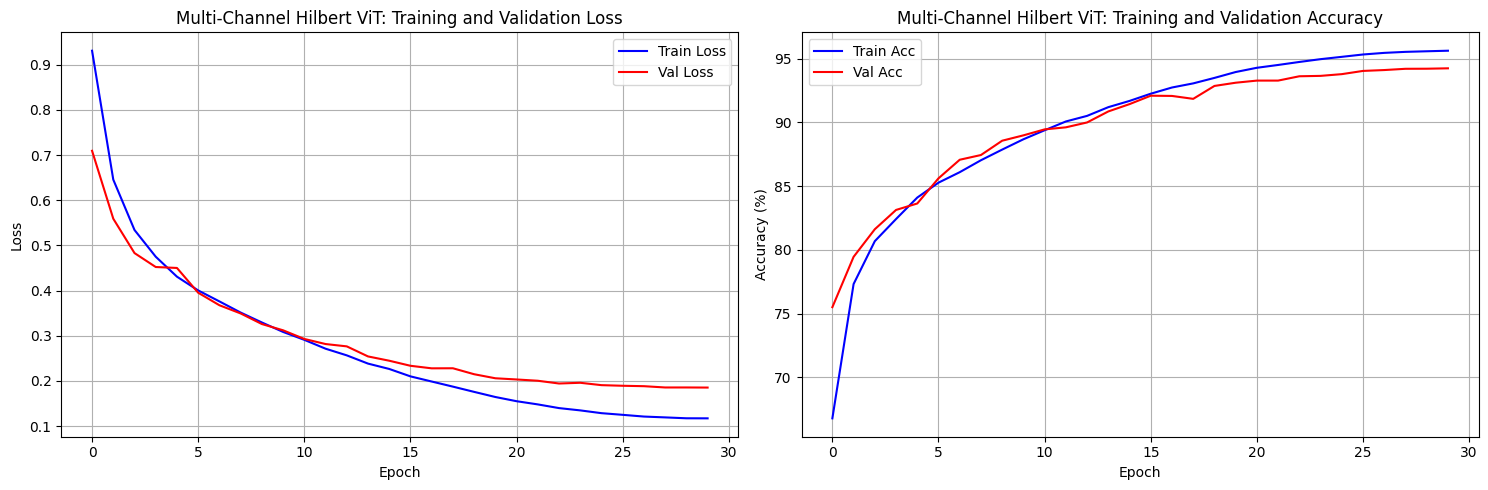


✓ Multi-Channel Hilbert ViT training complete!
✓ Spatial locality + semantic richness combined successfully


In [5]:
# Section 4: Training Pipeline
print("Preparing training pipeline for Multi-Channel Hilbert ViT...")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")

# Stratified train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ Data splits:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ Training setup complete")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting Multi-Channel Hilbert ViT training for {CONFIG['epochs']} epochs...")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_multichannel_hilbert_vit_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ Training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('Multi-Channel Hilbert ViT: Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('Multi-Channel Hilbert ViT: Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ Multi-Channel Hilbert ViT training complete!")
print(f"✓ Spatial locality + semantic richness combined successfully")

🔍 Multi-Channel Hilbert ViT Evaluation on Test Set
🎯 Multi-Channel Hilbert ViT Test Results:
✓ Test Accuracy: 94.32%
✓ Test Loss: 0.1809
✓ Samples evaluated: 16,200

📊 Per-Class Performance:
--------------------------------------------------------------------------------

📈 Overall Metrics:
✓ Macro Avg: Precision=0.946, Recall=0.943, F1=0.944
✓ Weighted Avg: Precision=0.946, Recall=0.943, F1=0.944


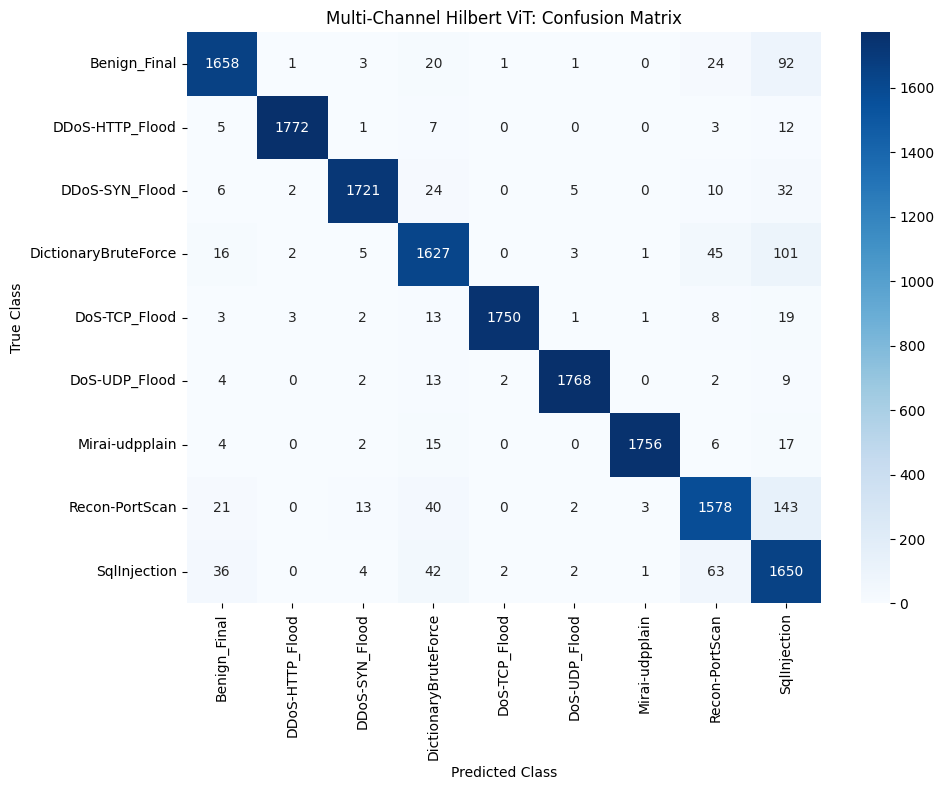


📊 Class-wise Accuracy:
   Benign_Final             :  92.1% (1,800 samples)
   DDoS-HTTP_Flood          :  98.4% (1,800 samples)
   DDoS-SYN_Flood           :  95.6% (1,800 samples)
   DictionaryBruteForce     :  90.4% (1,800 samples)
   DoS-TCP_Flood            :  97.2% (1,800 samples)
   DoS-UDP_Flood            :  98.2% (1,800 samples)
   Mirai-udpplain           :  97.6% (1,800 samples)
   Recon-PortScan           :  87.7% (1,800 samples)
   SqlInjection             :  91.7% (1,800 samples)

💡 Multi-Channel Hilbert ViT Key Results:
✓ Overall test accuracy: 94.32%
✓ Number of classes: 9
✓ Model complexity: 2,918,409 parameters
✓ Input format: 5-channel 32×32 Hilbert-mapped images
✓ Key advantage: Combines spatial locality (Hilbert) with semantic richness (5 channels)

📊 Performance Comparison with Other Methods:
   Standard 5-Channel:         93.30% (semantic richness only)
   RGB Hilbert:                92.11% (spatial locality only)
   Multi-Channel Hilbert:      94.32% (both com

In [6]:
# Section 5: Evaluation & Results Analysis
print("🔍 Multi-Channel Hilbert ViT Evaluation on Test Set")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_multichannel_hilbert_vit_model.pth'))
model.eval()

# Comprehensive evaluation
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# Run evaluation
test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 Multi-Channel Hilbert ViT Test Results:")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 Per-Class Performance:")
print("-" * 80)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:25s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Multi-Channel Hilbert ViT: Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
print(f"\n📊 Class-wise Accuracy:")
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(predictions[class_mask] == targets[class_mask]) * 100
        sample_count = np.sum(class_mask)
        class_accuracies.append((class_name, class_acc, sample_count))
        print(f"   {class_name:25s}: {class_acc:5.1f}% ({sample_count:,} samples)")

# Performance summary
print(f"\n💡 Multi-Channel Hilbert ViT Key Results:")
print(f"✓ Overall test accuracy: {test_accuracy:.2f}%")
print(f"✓ Number of classes: {CONFIG['num_classes']}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} Hilbert-mapped images")
print(f"✓ Key advantage: Combines spatial locality (Hilbert) with semantic richness (5 channels)")

# Compare with other methods
print(f"\n📊 Performance Comparison with Other Methods:")
print(f"   Standard 5-Channel:         93.30% (semantic richness only)")
print(f"   RGB Hilbert:                92.11% (spatial locality only)")
print(f"   Multi-Channel Hilbert:      {test_accuracy:.2f}% (both combined)")

# Save results for comparison
results_multichannel_hilbert = {
    'model_type': 'multichannel_hilbert_32x32',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'image_size': CONFIG['image_size'],
    'channels': CONFIG['channels'],
    'patch_size': CONFIG['patch_size'],
    'patches_per_image': (CONFIG['image_size']//CONFIG['patch_size'])**2,
    'embed_dim': CONFIG['embed_dim'],
    'num_heads': CONFIG['num_heads'],
    'num_layers': CONFIG['num_layers'],
    'encoding_type': 'hilbert_curve_multichannel',
    'spatial_locality': 'preserved_via_hilbert',
    'semantic_channels': channel_names,
    'class_accuracies': class_accuracies,
    'confusion_matrix': cm.tolist(),
    'classification_report': report
}

import json
with open('results_multichannel_hilbert_32x32.json', 'w') as f:
    json.dump(results_multichannel_hilbert, f, indent=2, default=str)

print(f"\n✓ Results saved to results_multichannel_hilbert_32x32.json")
print(f"✓ Multi-Channel Hilbert ViT evaluation complete!")
print(f"✓ Successfully combined spatial locality with semantic richness")